# NX-421 Mini Project — Group P, Variant 1 (PCA) with Preprocessing 

## GLM Only



## 4. GLM

### 4a. Import Libraries

In [2]:
# Data handling and visualization imports
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt



# NiLearn imports
#%pip install nilearn
# %pip install nibabel
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_design_matrix
from nilearn import plotting
from nilearn.reporting import get_clusters_table
from nilearn.image import mean_img, get_data, coord_transform
from nilearn.glm import threshold_stats_img

In [3]:
# Base image (motion corrected + smoothed)
img_path = "/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/fMRI_project/moco_smoothed-4mm.nii" ### TO BE REPLACED WITH YOUR PATH ###
img = nib.load(img_path)


Check number of scans and apparent duration.

It appears that no voxels were removed during functional preprocessing, since we still have a total 568 scans, which correspond to 284 in each run. 

In [4]:
TR = 0.72
n_scans = img.shape[-1]
scan_dur = n_scans * TR
print("n_scans:", n_scans, "scan_dur(s):", scan_dur) 

n_scans: 568 scan_dur(s): 408.96


In [5]:
# Load event files 
ev_LR_path = "/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/fMRI_project/subject101410/fMRI/tfMRI_MOTOR_LR/events_LR.csv"
ev_RL_path = "/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/fMRI_project/subject101410/fMRI/tfMRI_MOTOR_RL/events_RL.csv"
ev_LR = pd.read_csv(ev_LR_path) # in the functional preprocessing step for concatenation LR is placed first before RL
ev_RL = pd.read_csv(ev_RL_path)

In [6]:
# Clean event files

# ensure onset and duration are numeric
for df in (ev_LR, ev_RL):
    df["onset"] = pd.to_numeric(df["onset"], errors="coerce")
    df["duration"] = pd.to_numeric(df["duration"], errors="coerce")

# change condition column name for trial-type
ev_LR = ev_LR.rename(columns={"condition": "trial_type"})
ev_RL = ev_RL.rename(columns={"condition": "trial_type"})



In [7]:
print(ev_LR.head())
print(ev_RL.head())

   onset  duration trial_type
0    0.0       8.0        NaN
1    8.0       3.0        cue
2   11.0      12.0         rh
3   23.0       3.0        cue
4   26.0      12.0         lf
   onset  duration trial_type
0    0.0       8.0        NaN
1    8.0       3.0        cue
2   11.0      12.0         lh
3   23.0       3.0        cue
4   26.0      12.0         rf


In [8]:

# Observe that the RL run onsets need to be adjusted by adding the duration of the LR run
n_scans_run1 = n_scans // 2         # 284
dur_run1 = n_scans_run1 * TR        # 204.48 s
dur_run1
ev_RL['onset'] += dur_run1 # shift to follow Run 1 on timeline


In [9]:
print(ev_LR.tail())
print(ev_RL.head())

    onset  duration trial_type
19  159.0       3.0        cue
20  162.0      12.0         lh
21  174.0       3.0        cue
22  177.0      12.0         rf
23  189.0      15.5   fixation
    onset  duration trial_type
0  204.48       8.0        NaN
1  212.48       3.0        cue
2  215.48      12.0         lh
3  227.48       3.0        cue
4  230.48      12.0         rf


In [10]:
# Change NaN for Rest
ev_LR['trial_type'] = ev_LR['trial_type'].fillna('rest')
ev_RL['trial_type'] = ev_RL['trial_type'].fillna('rest')

In [11]:
# Check the cleaned event files
print(ev_LR.head())
print(ev_RL.head())

   onset  duration trial_type
0    0.0       8.0       rest
1    8.0       3.0        cue
2   11.0      12.0         rh
3   23.0       3.0        cue
4   26.0      12.0         lf
    onset  duration trial_type
0  204.48       8.0       rest
1  212.48       3.0        cue
2  215.48      12.0         lh
3  227.48       3.0        cue
4  230.48      12.0         rf


### 4c. Task Matrix

In [13]:
# Combine the two event files into one
events_1 = pd.concat([ev_LR, ev_RL], ignore_index=True)
events_1 ## almost exactly 408s

,onset,duration,trial_type
0,0.00,8.0,rest
1,8.00,3.0,cue
2,11.00,12.0,rh
3,23.00,3.0,cue
4,26.00,12.0,lf
5,38.00,3.0,cue
6,41.00,12.0,t
7,53.00,3.0,cue
8,56.00,12.0,rf
9,68.00,3.0,cue


Report the experimental design matrix to use for this subject, which you will be using in the following GLM analysis. 

Answer: The design matrix included seven task-related regressors (cue, fixation, left/right hand, left/right foot, and tongue), three polynomial drift terms, and one constant. Drift regressors modeled low-frequency trends in the BOLD signal. 

## 5. First Level Model

(568, 12) ['cue', 'fixation', 'lf', 'lh', 'rest', 'rf', 'rh', 't', 'drift_1', 'drift_2', 'drift_3', 'constant']


<Axes: label='conditions', ylabel='scan number'>

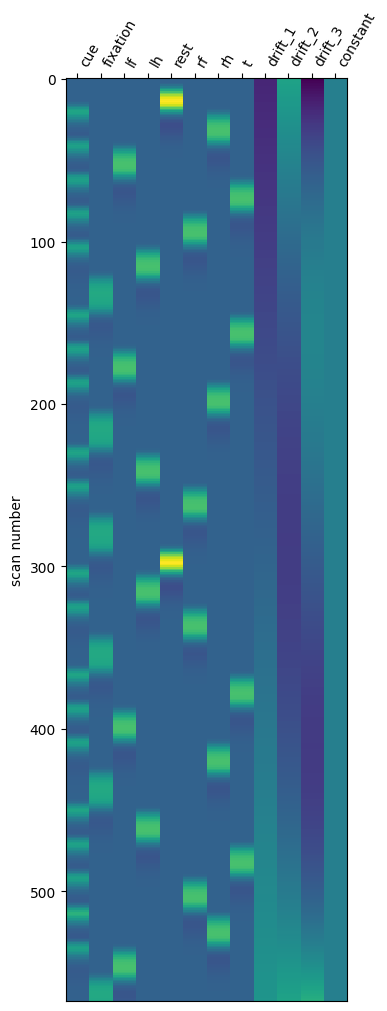

In [14]:
TR = 0.72  # seconds

# fit + design check
glm = FirstLevelModel(
    t_r=TR, 
    hrf_model='spm', # from lab
    smoothing_fwhm=None,
    noise_model='ar1',  # from lab
    standardize=False,
    drift_model='polynomial', # as seen in the lab ## is it very diff from make_drift?
    drift_order=3, # from lab
    high_pass=.01, # from lab
    verbose=0
).fit(img_path, events_1)

design = glm.design_matrices_[0]
print(design.shape, list(design.columns))
plot_design_matrix(design)

### 5a. Check Drift

In [15]:
drift_cols = [col for col in design.columns if 'drift' in col]
print("Drift columns:", drift_cols)


Drift columns: ['drift_1', 'drift_2', 'drift_3']


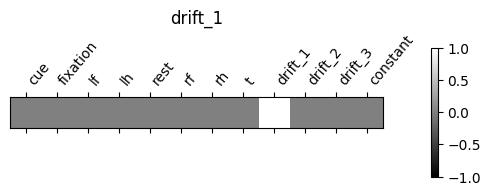

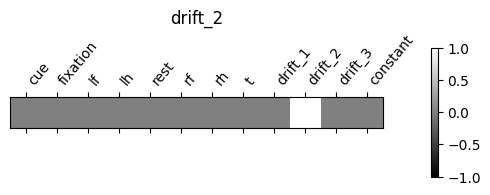

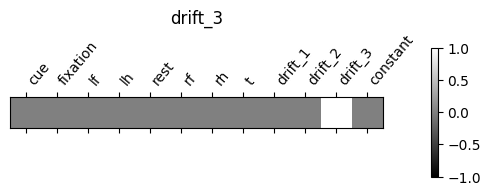

In [16]:
from nilearn.plotting import plot_contrast_matrix

for drift in drift_cols:
    plot_contrast_matrix(drift, design_matrix=design)
    plt.title(drift)
    plt.show()


/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_5629/10996214.py:6: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  bg = mean_img(img_path)


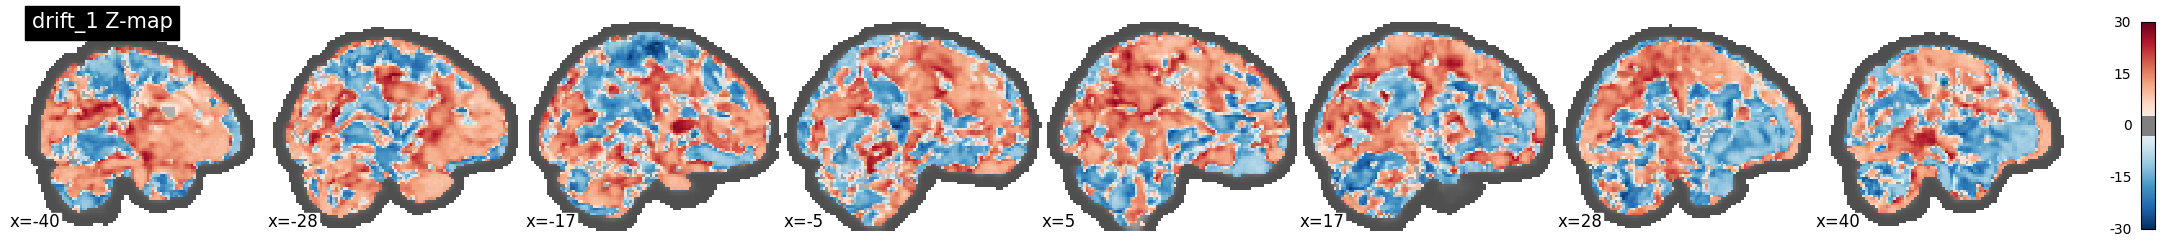

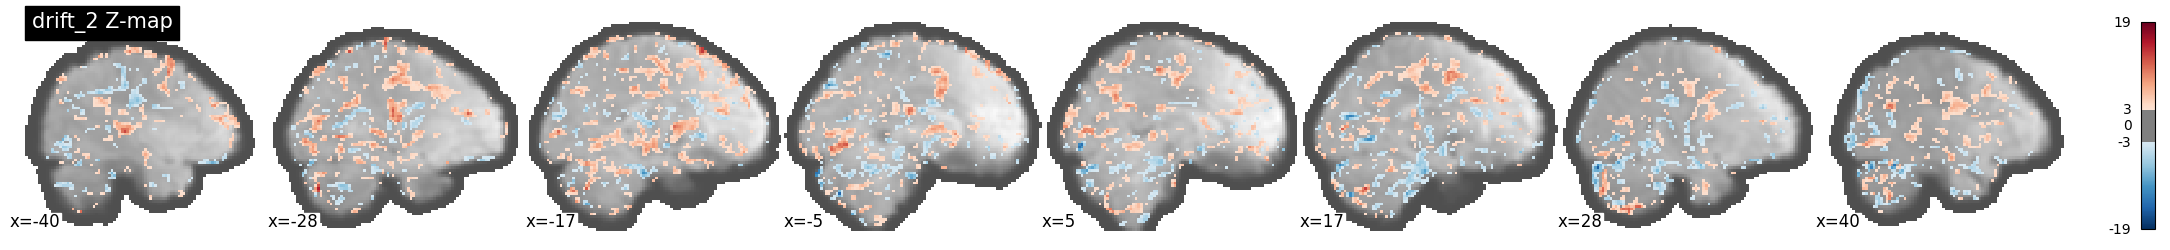

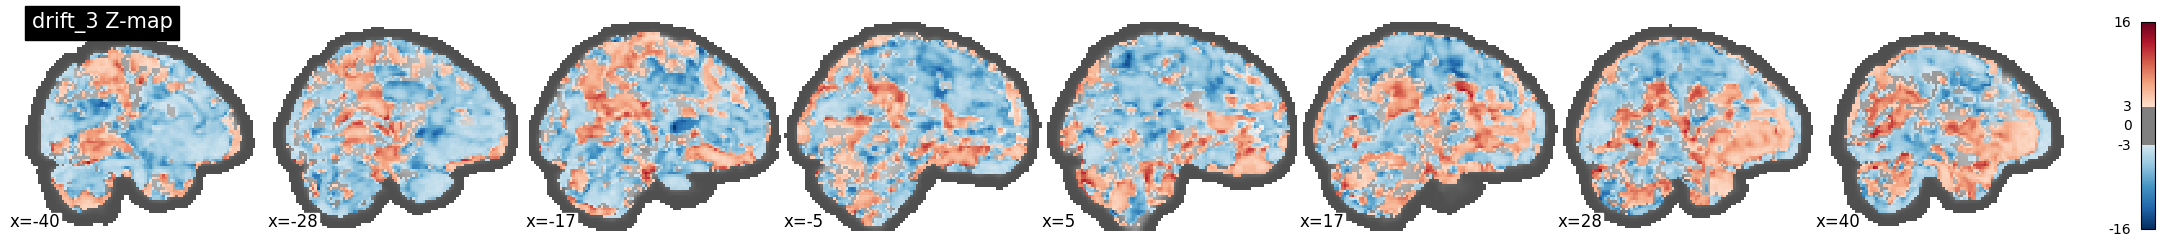

In [17]:
import os
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_stat_map

bg = mean_img(img_path)
folder_state_path = 'derivatives/GLM/drift_z_maps'
os.makedirs(folder_state_path, exist_ok=True)

for drift in drift_cols:
    z_map = glm.compute_contrast(drift, output_type="z_score")

    plot_stat_map(z_map, bg_img=bg, threshold=3.0, display_mode='x',
                  cut_coords=np.linspace(-40,40,8), black_bg=False,
                  title=f'{drift} Z-map')
    file_name = f"{drift}_z_map_uncorrected.nii.gz"
    nib.save(z_map, os.path.join(folder_state_path, file_name))
    plt.savefig(os.path.join(folder_state_path, f"{drift}_z_map.png"))
    plt.show()


### 5b. Statistical Maps: Task Related Regressors

Run the GLM at the level you deem reasonable and **report the statistical maps of each of the task-related regressors**. Briefly comment on the statistical maps and, if you can, relate them to the corresponding task. 

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_5629/391731775.py:4: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_image = mean_img(img)


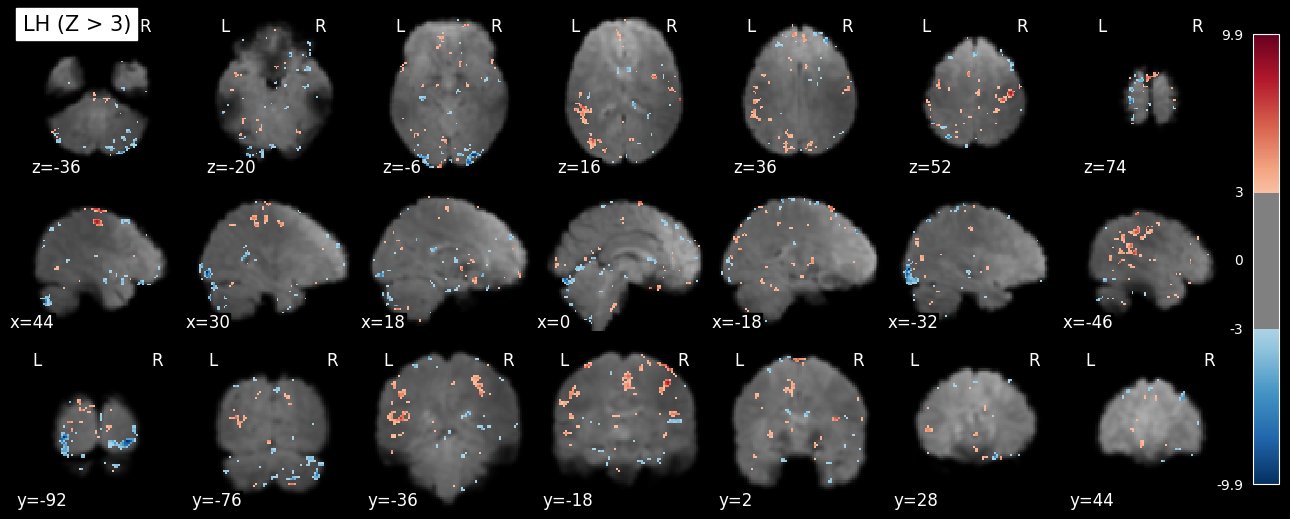

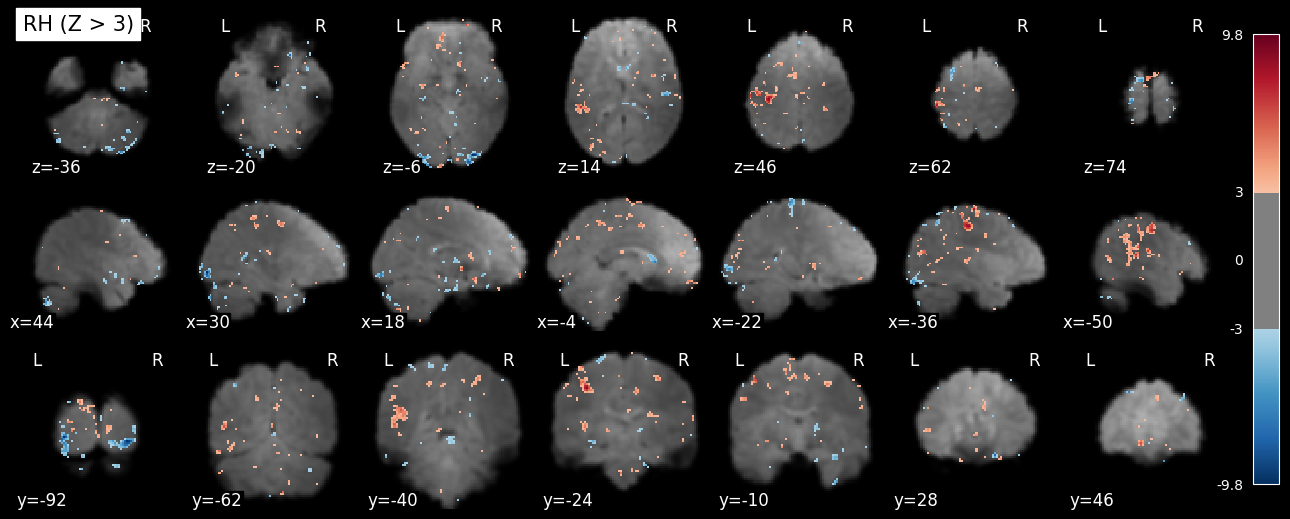

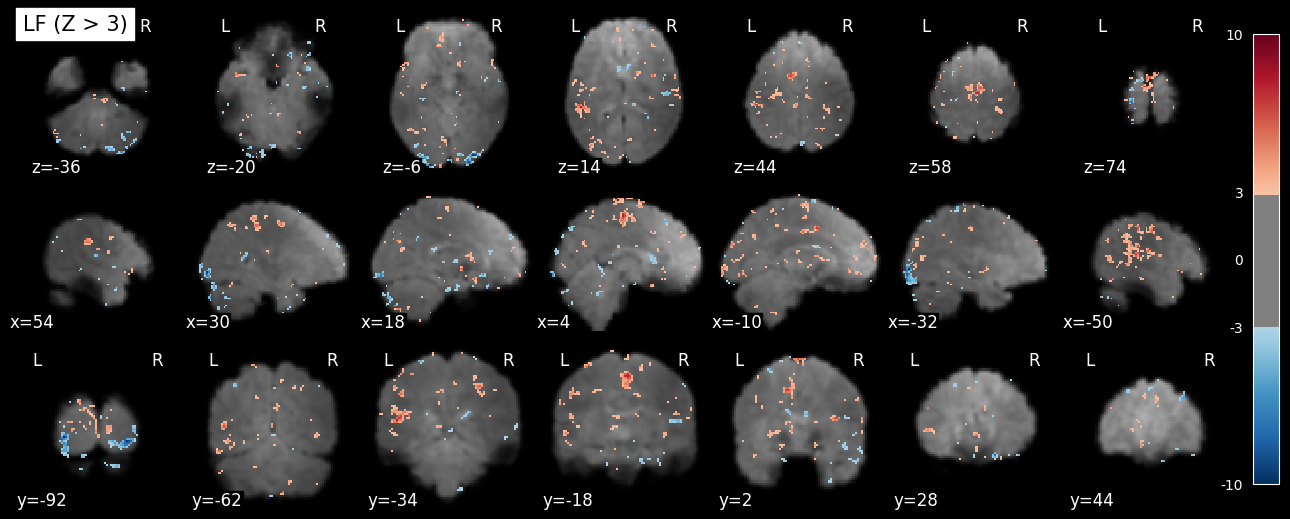

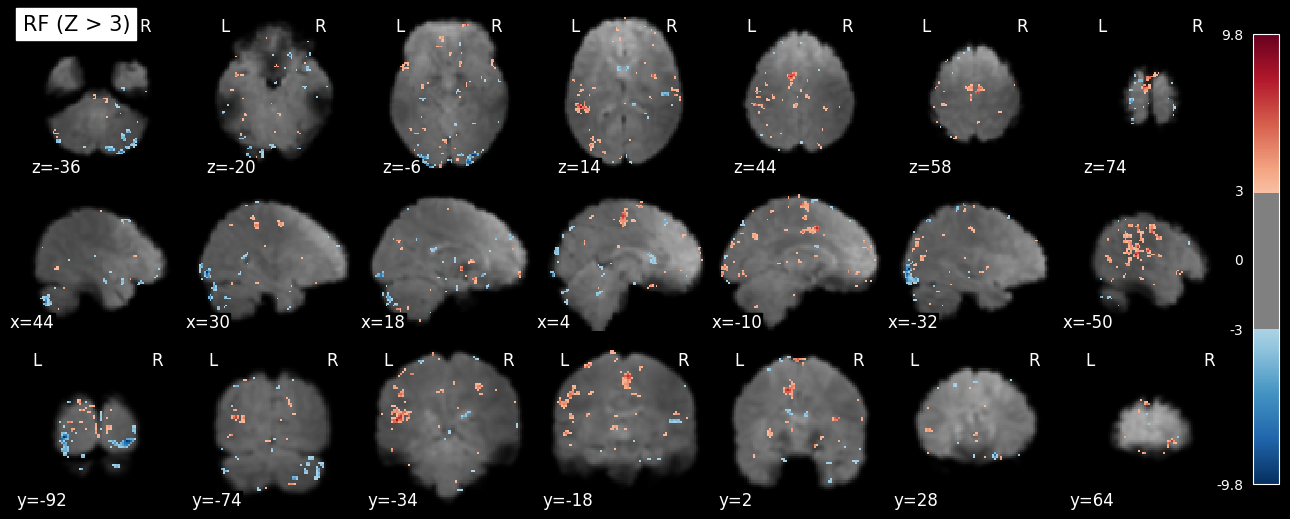

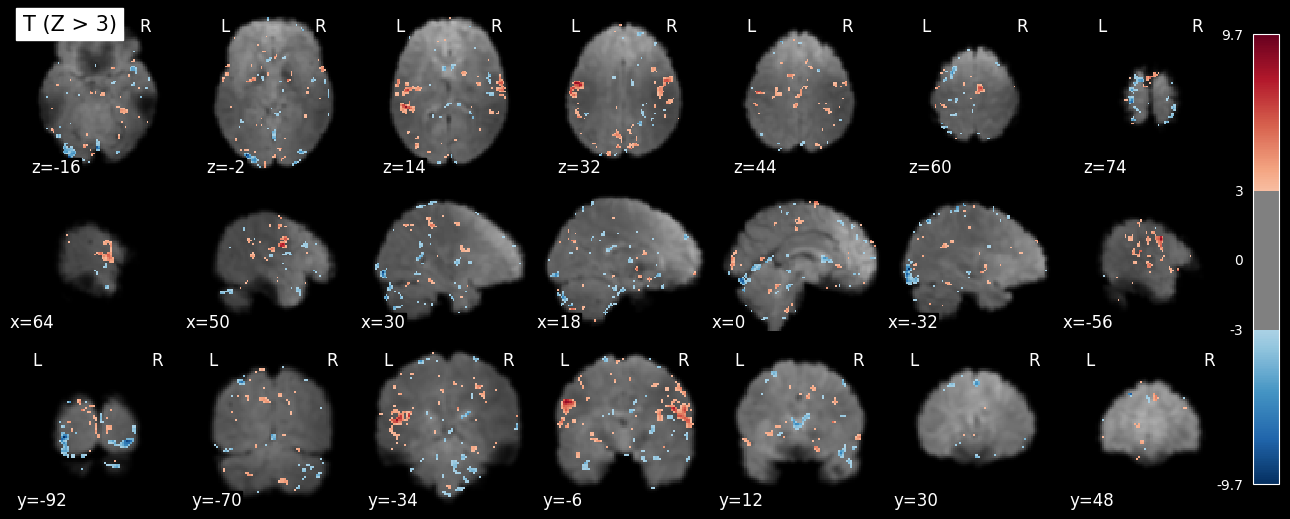

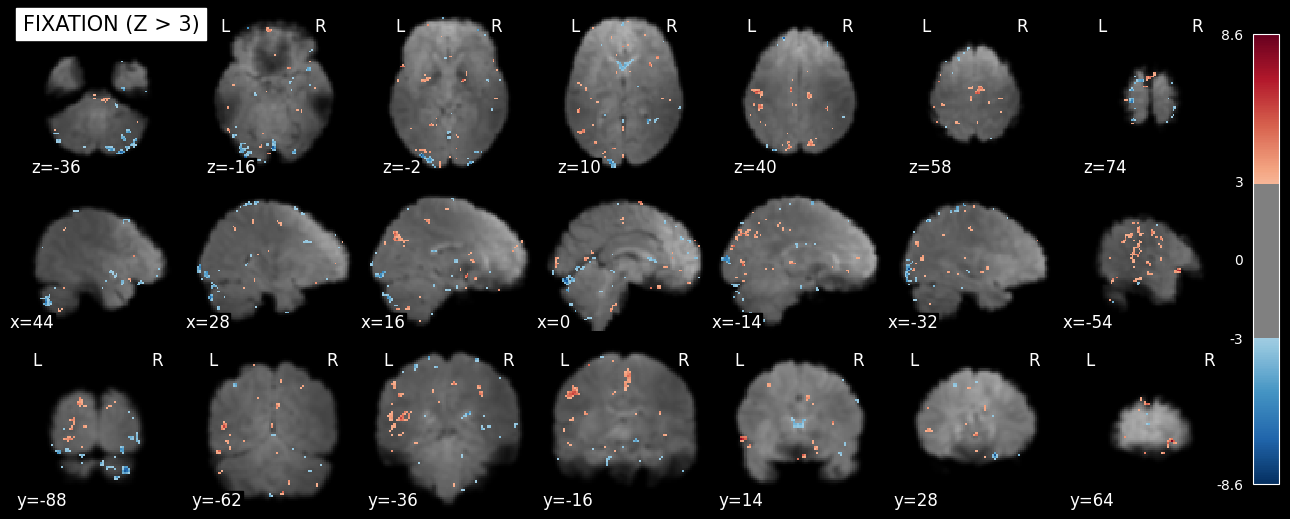

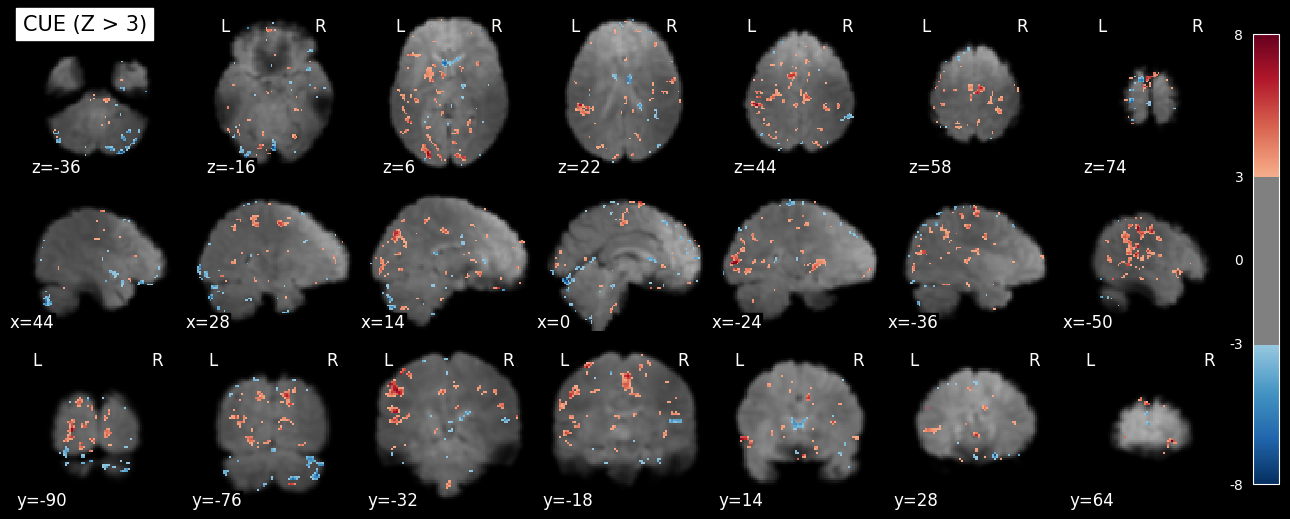

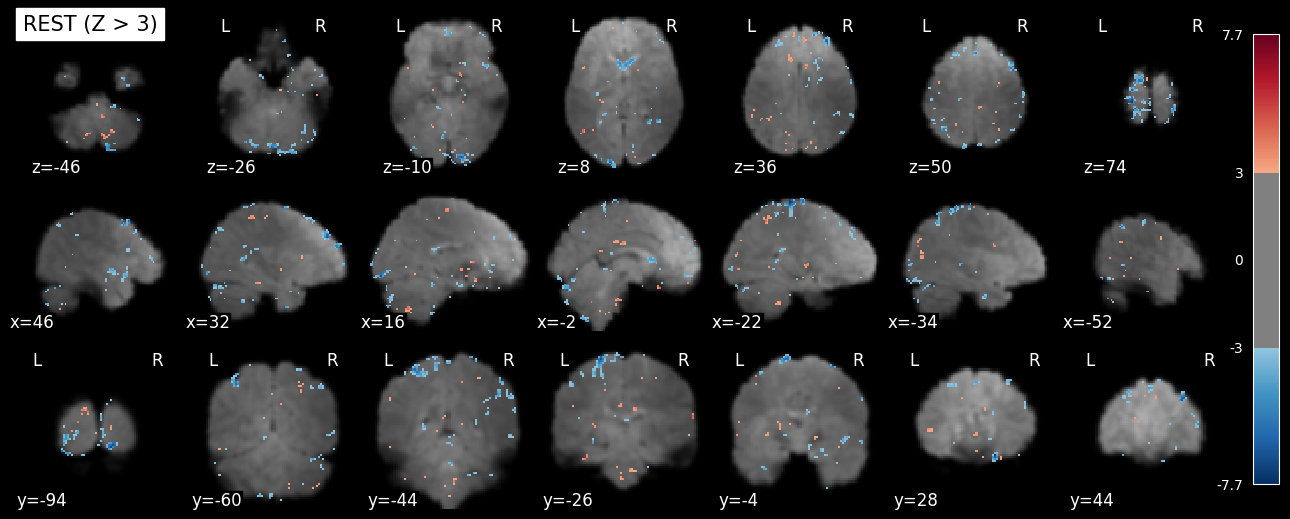

In [18]:
from nilearn import plotting

trial_types = ['lh', 'rh', 'lf', 'rf', 't', 'fixation', 'cue', 'rest']
mean_image = mean_img(img) 


# Loop over each trial type column to create and plot statistical maps
for cond in trial_types:
    # Compute statistical map for this condition/regressor
    z_map = glm.compute_contrast(cond, output_type="z_score")
    
    # Plot statistical map for the condition
    plotting.plot_stat_map(
        z_map, 
        bg_img= mean_image, 
        display_mode='mosaic',
         black_bg= True,
        threshold=3.0,  # adjust threshold as needed
        title=f"{cond.upper()} (Z > 3)"
    )


## 6. Contrasts

Using the results of the GLM analysis and a contrast vector of your choice, create the activation maps corresponding to the hand motion against feet motion. Please include in the report the contrast vector used and the contrast map you obtained. 

In [19]:
# 1) Hands(avg) > Feet(avg) + Tongue
z_hands_vs_feet_t = glm.compute_contrast(
    "(lh + rh)/2 - ((lf + rf)/2 + t)",
    output_type="z_score"
)

# 2) Feet(avg) > Hands(avg) + Tongue
z_feet_vs_hands_t = glm.compute_contrast(
    "(lf + rf)/2 - ((lh + rh)/2 + t)",
    output_type="z_score"
)

# 3) Diff between (1) and (2)  ==  2 * (Hands(avg) - Feet(avg))
z_diff_1_2 = glm.compute_contrast(
    "2 * ((lh + rh)/2 - (lf + rf)/2)",
    output_type="z_score"
) 
 
 
 ## We are keeping this one
# 4) Hands(avg) > Feet(avg) 
avg_hands_vs_avg_feet = glm.compute_contrast(
    "(lh + rh)/2 - (lf + rf)/2",
    output_type="z_score"
)

# 5) Feet(avg) > Hands(avg) 
avg_feet_vs_avg_hands = glm.compute_contrast(
    "(lf + rf)/2 - (lh + rh)/2",
    output_type="z_score"
)

### 6a. Statistical maps:

In [20]:
# Determine z-score threshold for significance 
from scipy.stats import norm
p_value = 0.001
z_score_threshold = norm.isf(p_value)
print(z_score_threshold) # 3.09 z for a p value of 0.001


3.090232306167813


### Uncorrected statistical maps: 

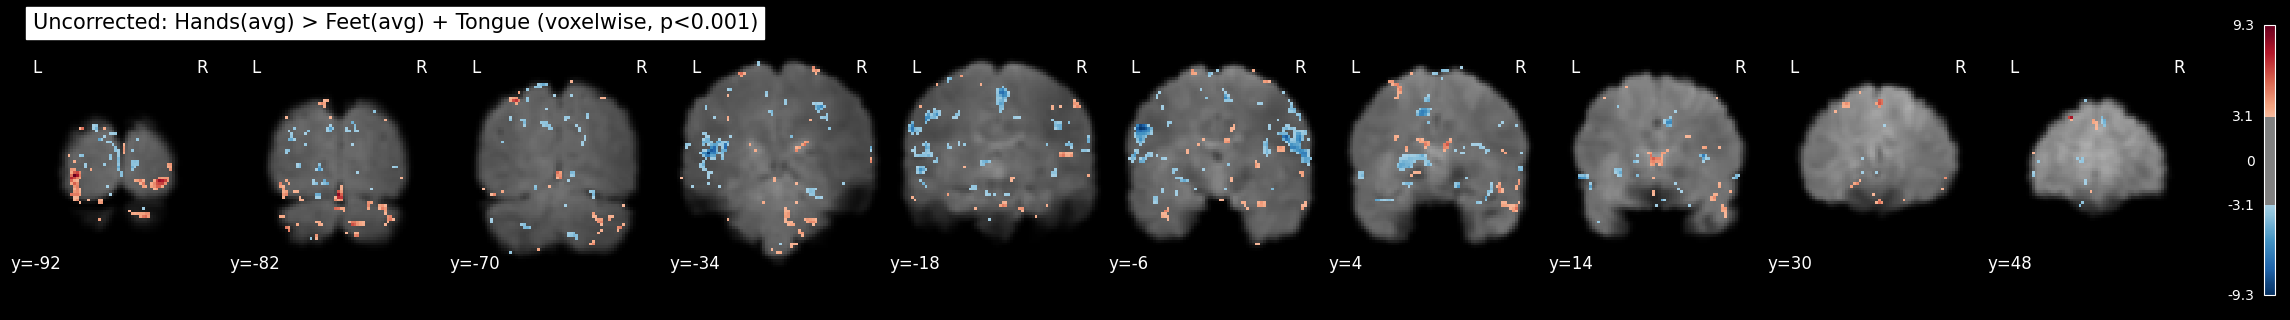

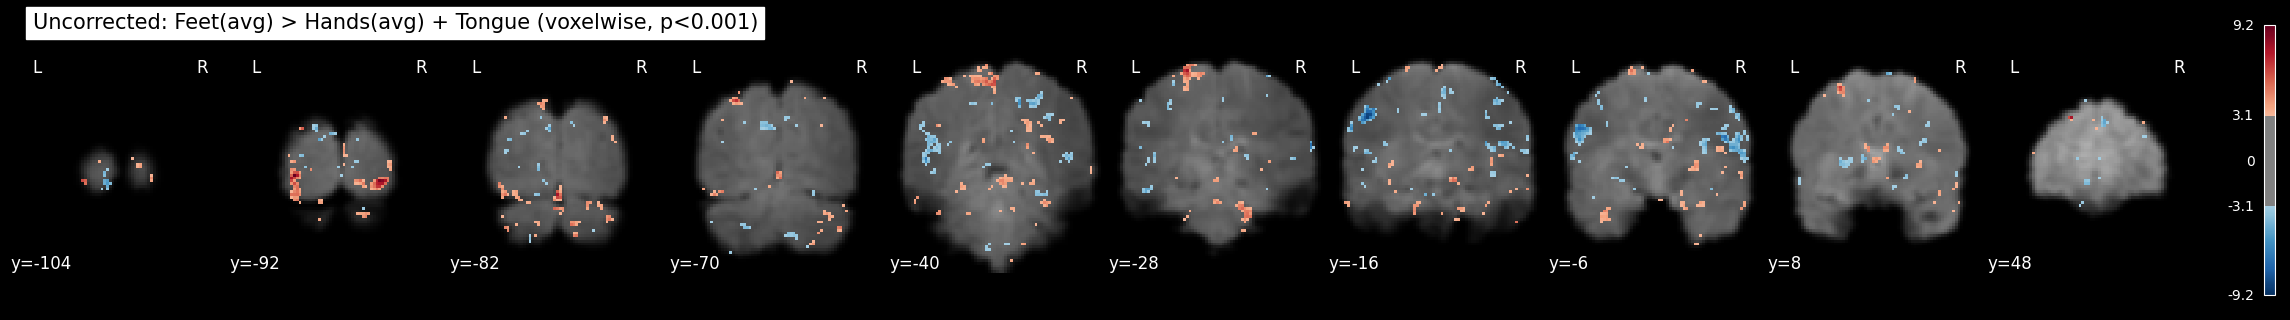

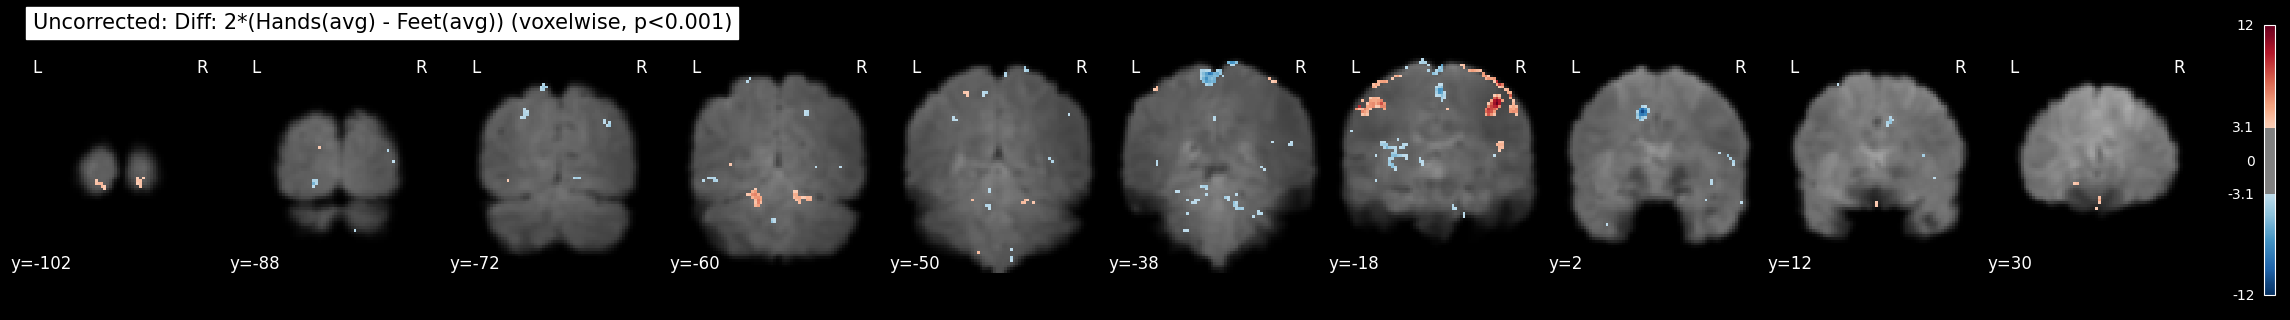

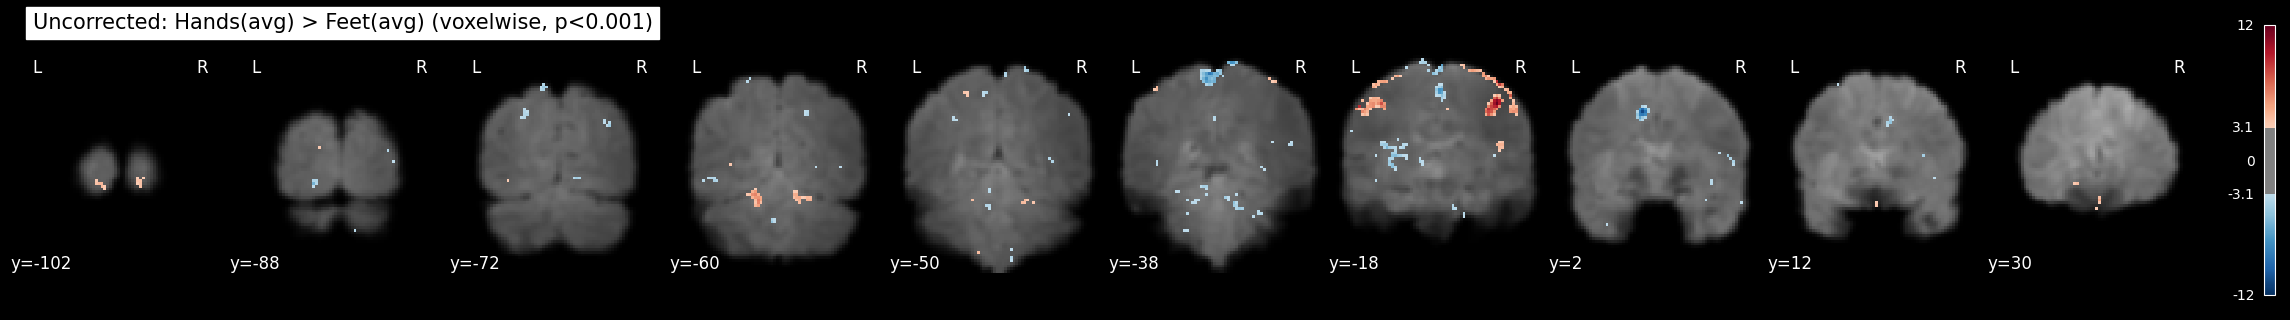

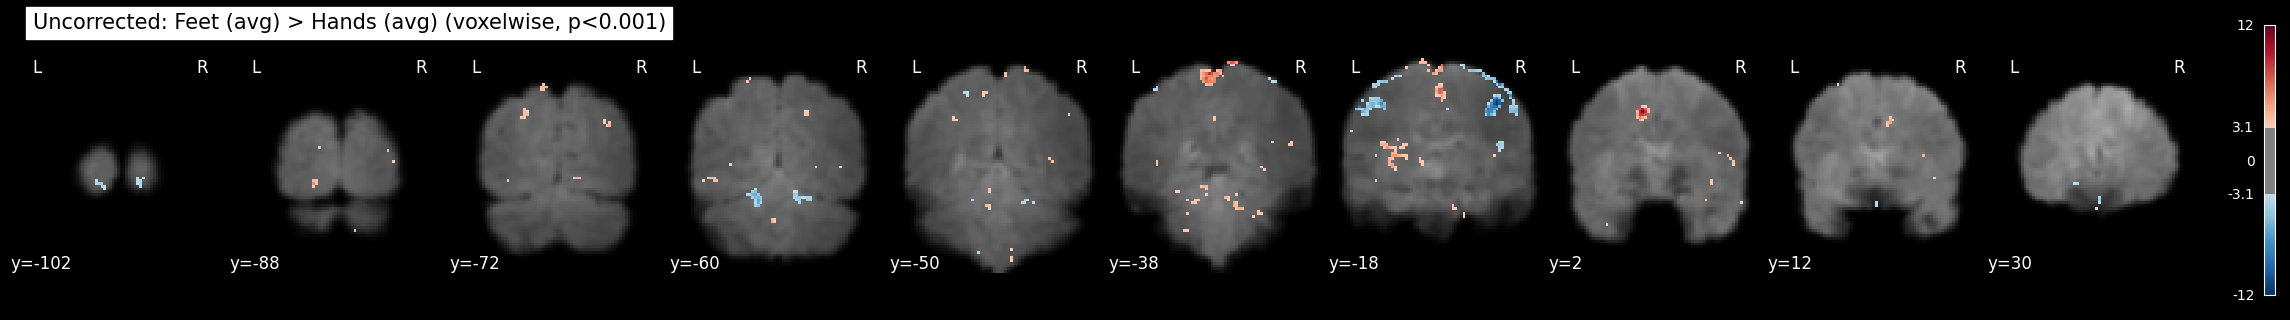

In [21]:
from nilearn.plotting import plot_stat_map
from scipy.stats import norm

# Define contrasts
contrast_maps = {
    "Hands(avg) > Feet(avg) + Tongue": z_hands_vs_feet_t,
    "Feet(avg) > Hands(avg) + Tongue": z_feet_vs_hands_t,
    "Diff: 2*(Hands(avg) - Feet(avg))": z_diff_1_2,
    "Hands(avg) > Feet(avg)": avg_hands_vs_avg_feet,
    "Feet (avg) > Hands (avg)": avg_feet_vs_avg_hands
}

for name, z_map in contrast_maps.items():
    plot_stat_map(
        z_map, bg_img=mean_image, threshold=z_score_threshold,
        display_mode='y', cut_coords=10, black_bg=True,
        title=f"Uncorrected: {name} (voxelwise, p<{p_value})"
    )


### FDR and Cluster Corrected Plots

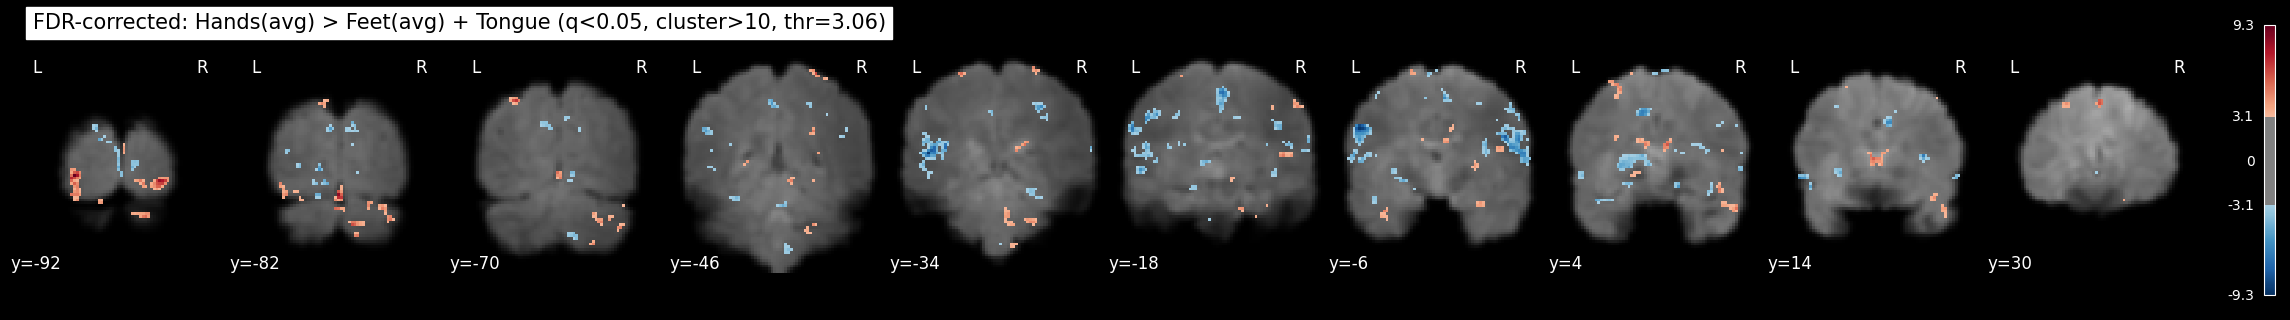

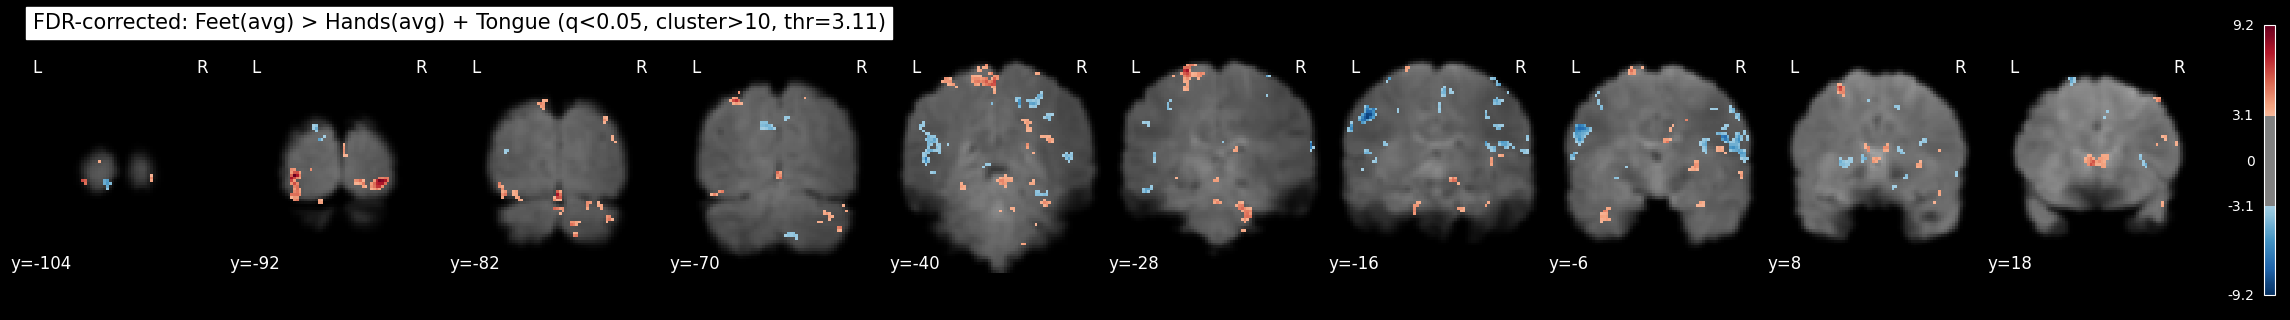

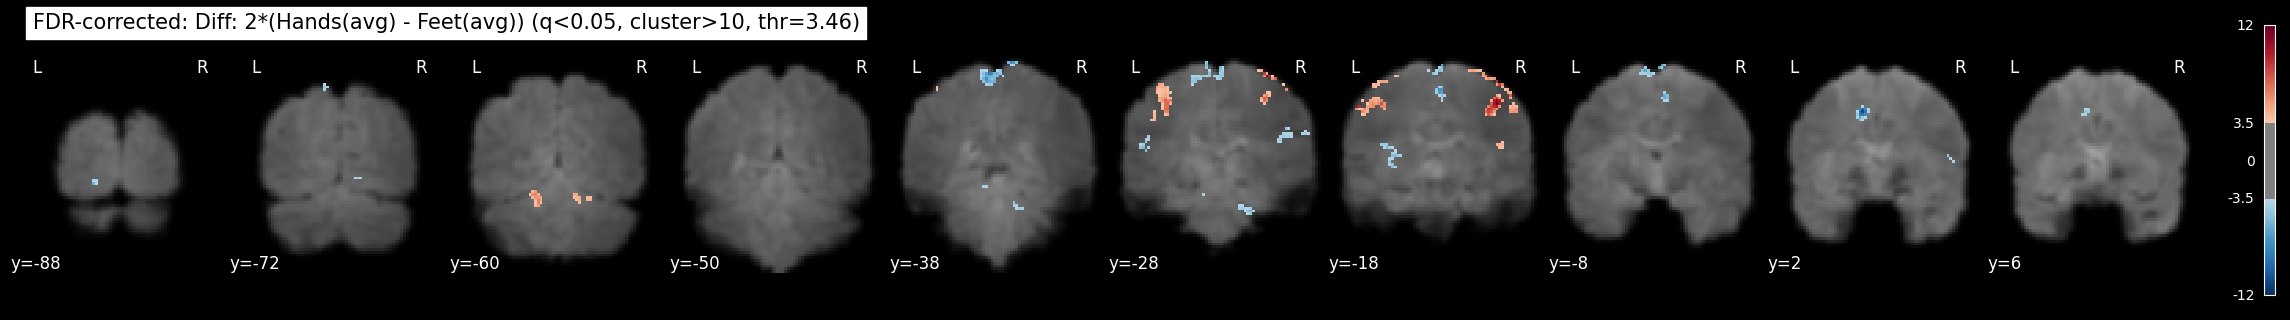

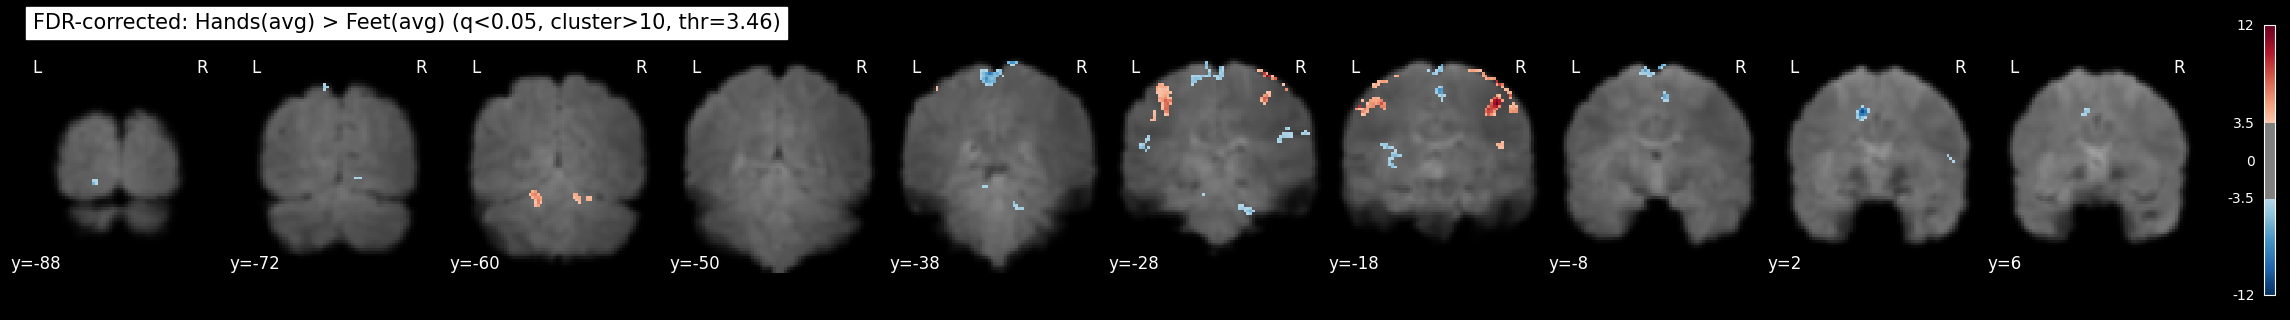

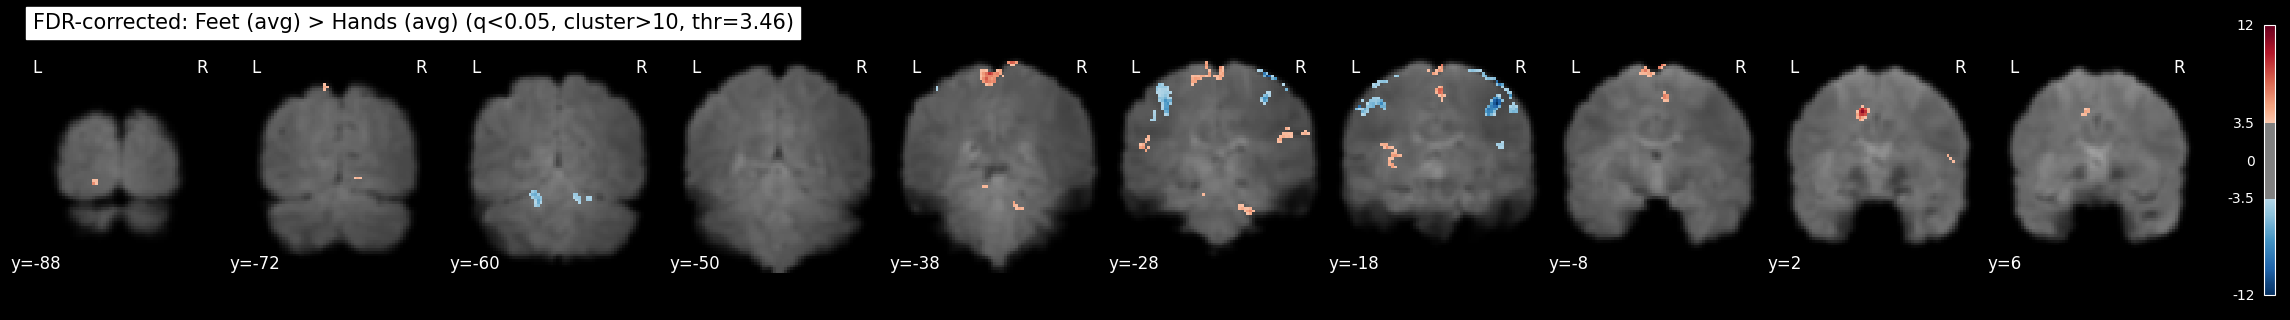

In [22]:
from nilearn.glm import threshold_stats_img

fdr_rate = 0.05
cluster_size = 10

for name, z_map in contrast_maps.items():
    clean_map, fdr_thresh = threshold_stats_img(
        z_map, alpha=fdr_rate, height_control='fdr',
        cluster_threshold=cluster_size, two_sided=True
    )
    plot_stat_map(
        clean_map, bg_img=mean_image, threshold=fdr_thresh,
        display_mode='y', cut_coords=10, black_bg=True,
        title=f"FDR-corrected: {name} (q<{fdr_rate}, cluster>{cluster_size}, thr={fdr_thresh:.2f})"
    )


### 6b. Atlas Superposition 

To better interpret your results, overlay the contrast map with the AAL atlas parcellation (hint: take a look at NiLearn). 

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_5629/1672685052.py:4: DeprecationWarning: Starting in version 0.13, the default fetched mask will beAAL 3v2 instead.
  aal = datasets.fetch_atlas_aal(version='SPM12')
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_5629/1672685052.py:9: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  aal_resampled = image.resample_to_img(aal_img, avg_hands_vs_avg_feet, interpolation='nearest')
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_5629/1672685052.py:9: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  aal_resampled = image.resample_to_img(aal_img, avg_hands_vs_avg_feet, interpolation='nearest')


[fetch_atlas_aal] Dataset found in /Users/pamelavandenenden/nilearn_data/aal_SPM12


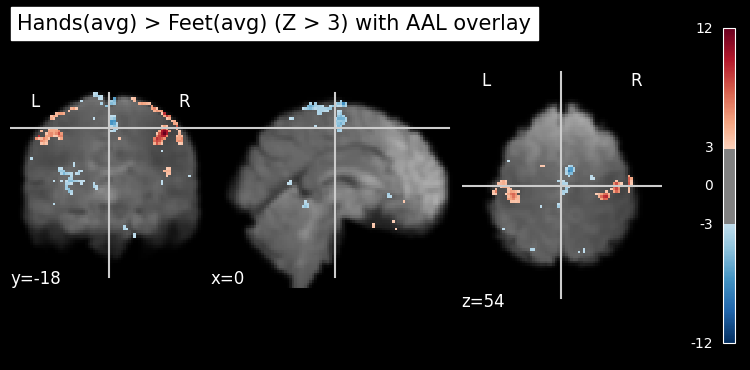

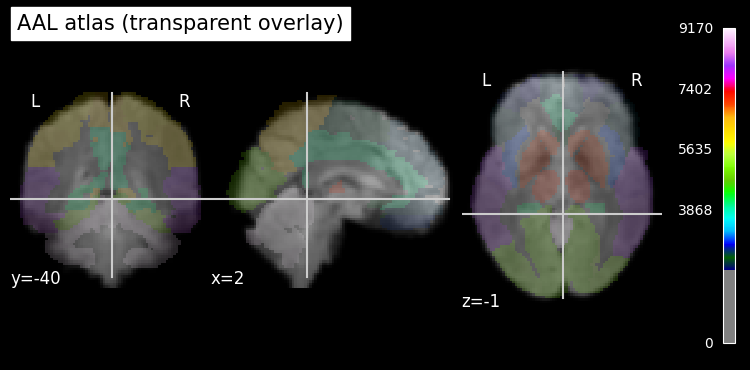

In [28]:
from nilearn import datasets, plotting, image

# Load the AAL atlas
aal = datasets.fetch_atlas_aal(version='SPM12')
aal_img = image.load_img(aal.maps)
aal_labels = aal.labels

# Make sure atlas resolution matches data
aal_resampled = image.resample_to_img(aal_img, avg_hands_vs_avg_feet, interpolation='nearest')

# Overlay AAL on contrast map
plotting.plot_stat_map(
    z_diff_1_2,
    bg_img=bg,
    threshold=3.0,
    display_mode='ortho',
    cut_coords=(0, -18, 54),   # around motor cortex
    title="Hands(avg) > Feet(avg) (Z > 3) with AAL overlay",
)
plotting.plot_roi(
    aal_resampled,
    bg_img=bg,
    alpha=0.15,
    title="AAL atlas (transparent overlay)"
)

### 6c. Peak Clusters

Report in which brain regions you find maximal contrast. (Note: the functional data are already in MNI space, so there is no need to do coregistration and normalization!) 

Answer: 
•	Peak 1: MNI [44, −18, 50], Z=12.13 — right precentral gyrus (primary motor cortex, hand area).
•	Peak 2: MNI [36, −28, 70], Z=10.95 — supplementary motor area / superior medial frontal cortex.
•   Peak 3: MNI [−38, −22, 50], Z=9.60 — left precentral gyrus (M1 hand area).
•	Peak 4: MNI [−14, −60, −20], Z=6.31 — left cerebellum (motor regions).


In [29]:
from nilearn.reporting import get_clusters_table

# ==== Hand > Feet ====
peaks_hand = get_clusters_table(avg_hands_vs_avg_feet, stat_threshold=3.0, cluster_threshold=10)

main_peaks_hand = peaks_hand[peaks_hand["Cluster Size (mm3)"].notna()].copy()
main_peaks_hand = main_peaks_hand.sort_values("Peak Stat", ascending=False)

print("\nHighest peaks:  Hand > Feet")
print(main_peaks_hand[["Cluster ID", "X", "Y", "Z", "Peak Stat", "Cluster Size (mm3)"]].head(8))


# ==== Feet > Hand ====
peaks_feet = get_clusters_table(avg_feet_vs_avg_hands, stat_threshold=3.0, cluster_threshold=10)

main_peaks_feet = peaks_feet[peaks_feet["Cluster Size (mm3)"].notna()].copy()
main_peaks_feet = main_peaks_feet.sort_values("Peak Stat", ascending=False)

print("\nHighest peaks: Feet > Hand")
print(main_peaks_feet[["Cluster ID", "X", "Y", "Z", "Peak Stat", "Cluster Size (mm3)"]].head(8))


Top 8 peaks: Hand > Feet
  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  44.0 -18.0  50.0  12.306822               1976
3          2  36.0 -28.0  70.0  11.161935               2112
4         2a  46.0 -16.0  64.0  10.182865                   
1         1a  40.0 -20.0  42.0  10.080422                   
7          3 -38.0 -22.0  50.0   9.575337               3232
2         1b  36.0 -26.0  54.0   9.287199                   
5         2b  52.0 -22.0  58.0   9.114117                   
8         3a -56.0 -18.0  48.0   9.105007                   

Top 8 peaks: Feet > Hand
  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  -6.0 -10.0  74.0  11.389351               3992
4          2 -10.0   2.0  44.0  11.110090                688
1         1a  -6.0 -38.0  72.0   8.796547                   
2         1b -12.0 -14.0  72.0   8.526973                   
5          3   6.0  -6.0  54.0   8.397598                600
6          4  10.0 -40.0  80.0   